In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
import warnings
warnings.simplefilter(action='ignore')
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

## Regression

#### Chia dữ liệu thành train và validation

In [12]:
np.random.seed(75)
# Tạo dataframe chứa dữ liệu train và test
data_train = pd.read_csv("FE_data_train.csv")
data_test = pd.read_csv("FE_data_test.csv")
df_train = pd.DataFrame()
df_validation = pd.DataFrame()
df_train, df_validation = train_test_split(data_train, test_size=0.1)
# Kiểm tra số lượng mẫu trong tập train và test
print("Số mẫu trong tập train:", len(df_train))
print("Số mẫu trong tập validation:", len(df_validation))
print("Số mẫu trong tập test:", len(data_test))

Số mẫu trong tập train: 1116
Số mẫu trong tập validation: 125
Số mẫu trong tập test: 190


In [13]:
data_train = df_train.copy().reset_index().drop('index', axis=1)
data_validation = df_validation.copy().reset_index().drop('index', axis=1)

x_train = data_train.drop('Giá nhà (Tỷ)', axis=1)
y_train = data_train['Giá nhà (Tỷ)']
x_validate = data_validation.drop('Giá nhà (Tỷ)', axis=1)
y_validate = data_validation['Giá nhà (Tỷ)']
x_test = data_test.drop('Giá nhà (Tỷ)', axis=1)
y_test = data_test['Giá nhà (Tỷ)']

### Linear Regression Model

In [14]:
lrg = LinearRegression()
lrg.fit(x_train, y_train)
y_predict_linear_no = lrg.predict(x_validate)
r2_linear_no = r2_score(y_validate, y_predict_linear_no)
print("R2 Score (validate):", r2_linear_no)

R2 Score (validate): 0.5745985042723976


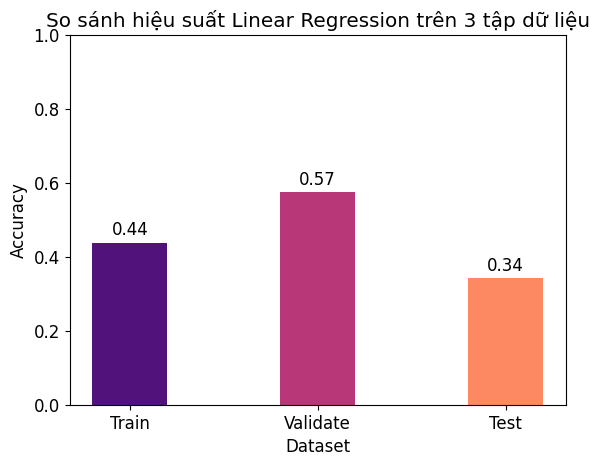

In [15]:
sns.set_palette("magma")
def compare_3_data(title, accuracys):
    labels = ['Train', 'Validate', 'Test']
    x = range(len(labels))
    colors = sns.color_palette("magma", len(labels)) # Lấy danh sách màu từ palette
    plt.bar(x, accuracys, color=colors, width=0.4) # Sử dụng danh sách màu cho mỗi cột
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks([i for i in x], labels)
    # Giới hạn giá trị trục y từ 0 đến 1
    plt.ylim(0, 1)
    for i, v in enumerate(accuracys):
        plt.text(i, v + 0.02, str(round(v, 2)), ha='center')
    plt.show()
    
acc = []
predict_train_linear = lrg.predict(x_train)
predict_validate_linear = lrg.predict(x_validate)
predict_test_linear = lrg.predict(x_test)
acc.extend([r2_score(y_train, predict_train_linear), r2_score(y_validate, predict_validate_linear), r2_score(y_test, predict_test_linear)])
compare_3_data("So sánh hiệu suất Linear Regression trên 3 tập dữ liệu", acc)


### Gradient Boosting Regression

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Khởi tạo mô hình GradientBoostingRegressor
gb_reg = GradientBoostingRegressor()

# Định nghĩa lưới các giá trị của các siêu tham số cần tinh chỉnh
param_grid = {
    'n_estimators': [30, 50, 100, 200, 300],
    'max_depth': [2, 3, 5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
}

# Khởi tạo RandomizedSearchCV với mô hình GradientBoostingRegressor và lưới tham số
random_search = RandomizedSearchCV(estimator=gb_reg,
                                   param_distributions=param_grid,
                                   cv=5,
                                   scoring='neg_mean_absolute_error',
                                   random_state=109)

# Tiến hành tinh chỉnh các siêu tham số trên tập huấn luyện
random_search.fit(x_train, y_train)

# Lấy ra các siêu tham số tốt nhất
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Khởi tạo lại mô hình GradientBoostingRegressor với các siêu tham số tốt nhất
best_gb_reg = GradientBoostingRegressor(**best_params)

# Huấn luyện lại mô hình trên toàn bộ tập huấn luyện
best_gb_reg.fit(x_train, y_train)

# Dự đoán trên tập kiểm tra
y_predict_gb = best_gb_reg.predict(x_validate)

# Đánh giá mô hình
mse = mean_squared_error(y_validate, y_predict_gb, squared=False)
r2 = r2_score(y_validate, y_predict_gb)

print("Mean Squared Error:", mse)
print("R-squared Score (validate):", r2)

Best Parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.15}
Mean Squared Error: 3.155606145292601
R-squared Score (validate): 0.7219284820371341


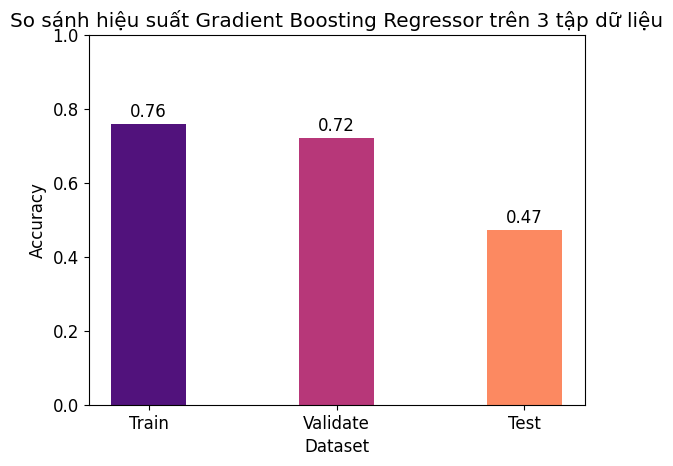

In [17]:
acc = []
predict_train_gb = best_gb_reg.predict(x_train)
predict_validate_gb = best_gb_reg.predict(x_validate)
predict_test_gb = best_gb_reg.predict(x_test)
acc.extend([r2_score(y_train, predict_train_gb), r2_score(y_validate, predict_validate_gb), r2_score(y_test, predict_test_gb)])
compare_3_data("So sánh hiệu suất Gradient Boosting Regressor trên 3 tập dữ liệu", acc)

### So sánh giá nhà giữa dữ liệu dự đoán và dữ liệu thực tế giữa Linear Regression với Gradient Boosting Regressor

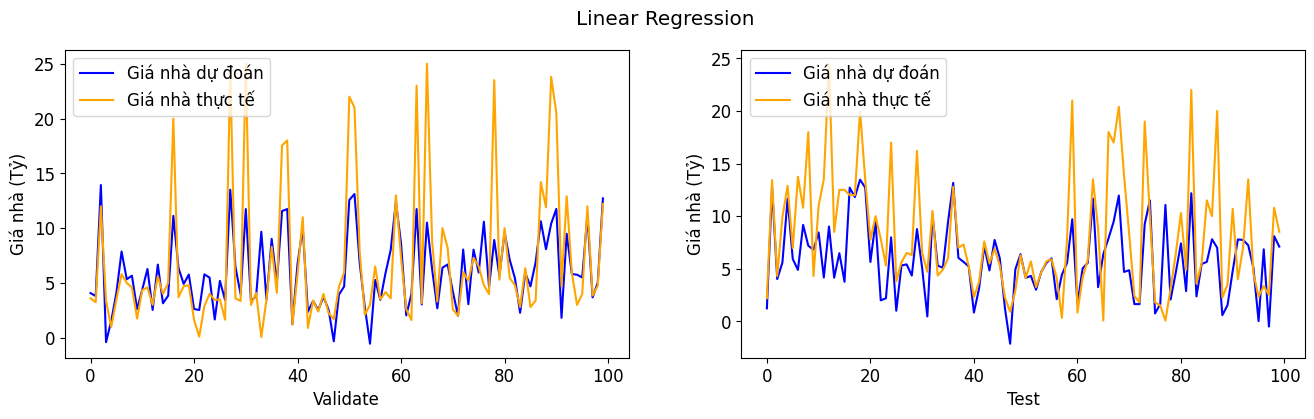

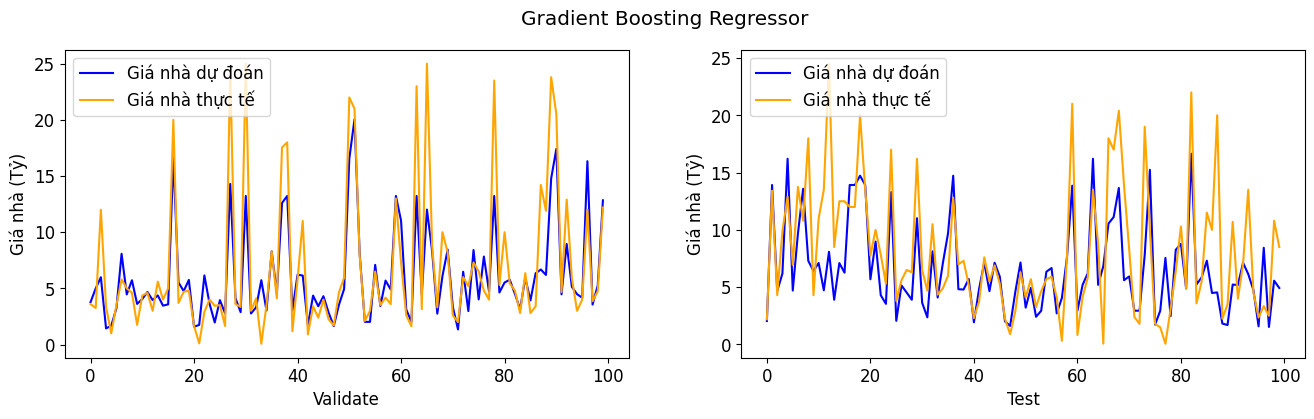

In [18]:
def plot_predicted_actual(y_predict, title):
  plt.figure(figsize=(16, 4))
  stt = 1
  for i in range(0, 3, 2):
      plt.subplot(1, 2, stt)
      stt += 1 
      plt.plot(y_predict[i][:100], label='Giá nhà dự đoán', color='blue')
      plt.plot(y_predict[i+1][:100], label='Giá nhà thực tế', color='orange')
      plt.legend(loc='upper left')
      plt.ylabel('Giá nhà (Tỷ)')
      plt.suptitle(title)
      if i == 0 :
        plt.xlabel('Validate')
      else:
        plt.xlabel('Test')
  plt.show()

y_predict_1 = [predict_validate_linear, y_validate, predict_test_linear, y_test]
title = "Linear Regression"
plot_predicted_actual(y_predict_1, title)

y_predict_2 = [predict_validate_gb, y_validate, predict_test_gb, y_test]
title = "Gradient Boosting Regressor"
plot_predicted_actual(y_predict_2, title)

### Đánh giá mô hình

In [19]:
def accuracy_score(y_validate, y_predict):
  # R-squared (R2)
  r2 = r2_score(y_validate, y_predict)
  # Root Mean Square Error (RMSE)
  rmse = mean_squared_error(y_validate, y_predict, squared=False)
  # Mean Absolute Error (MAE)
  mae = mean_absolute_error(y_validate, y_predict)

  return (r2, rmse, mae)

In [20]:
compare_data = []
r2_linear1, rmse_linear1, mae_linear1 = accuracy_score(y_train, predict_train_linear)
r2_gb1, rmse_gb1, mae_gb1 = accuracy_score(y_train, predict_train_gb)

r2_linear2, rmse_linear2, mae_linear2 = accuracy_score(y_validate, predict_validate_linear)
r2_gb2, rmse_gb2, mae_gb2 = accuracy_score(y_validate, predict_validate_gb)

r2_linear, rmse_linear, mae_linear = accuracy_score(y_test, predict_test_linear)
r2_gb, rmse_gb, mae_gb = accuracy_score(y_test, predict_test_gb)

compare_data.append(["Train", "R2", r2_linear1, r2_gb1])
compare_data.append(["Validate", "R2", r2_linear2, r2_gb2])
compare_data.append(["Test", "R2", r2_linear, r2_gb])

compare_data.append(["Train", "RMSE", rmse_linear1, rmse_gb1])
compare_data.append(["Validate", "RMSE", rmse_linear2, rmse_gb2])
compare_data.append(["Test", "RMSE", rmse_linear, rmse_gb])

compare_data.append(["Train", "MAE", mae_linear1, mae_gb1])
compare_data.append(["Validate", "MAE", mae_linear2, mae_gb2])
compare_data.append(["Test", "MAE", mae_linear, mae_gb])

result = pd.DataFrame(compare_data, columns=["Dataset", "Score", "Linear Regression", "Gradient Boosting"])
result

,Dataset,Score,Linear Regression,Gradient Boosting
0,Train,R2,0.438692,0.759692
1,Validate,R2,0.574599,0.721928
2,Test,R2,0.343190,0.471675
3,Train,RMSE,3.637806,2.380254
4,Validate,RMSE,3.903049,3.155606
5,Test,RMSE,4.251547,3.813096
6,Train,MAE,2.486714,1.428955
7,Validate,MAE,2.322410,1.882115
8,Test,MAE,2.961990,2.709157


## Kết luận

Dựa vào kết quả so sánh, ta thấy Gradient Boosting Regression cho số liệu đánh giá tốt hơn vì:
- Số đo R2 của mô hình này cao hơn do đó mô hình có độ tin cậy cao hơn
- Số đo RMSE và MAE của mô hình thấp hơn vì vậy mô hình có độ tin cậy càng cao bởi càng dần về 0 thì càng chứng minh mô hình ít bị sai số nhất  

Qua đó chọn ra mô hình phù hợp hơn cho bài toán đã đề ra là: Gradient Boosting Regression  
Tuy nhiên, hiệu suất ở tập kiểm thử chưa tốt do mô hình gặp khó khăn trong việc dự đoán các giá nhà ở mức cao (trên 15 tỷ).